# H-1B Visa: Prevailing Wage Prediction Model

This notebook builds and trains multiple machine learning models to predict **PREVAILING_WAGE** using employer name, year, work location, and occupation as features.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Load Dataset
df = pd.read_csv('h1b_kaggle_1000.csv')

# Display dataset info
print("Dataset Shape:", df.shape)
print("\nFirst Few Rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nTarget Variable Statistics:")
print(df['PREVAILING_WAGE'].describe())

Dataset Shape: (1000, 11)

First Few Rows:
   Unnamed: 0 CASE_STATUS              EMPLOYER_NAME  \
0     1506203      DENIED                  TILA INC.   
1     1741121   CERTIFIED        DATAWIN SYSTEMS INC   
2     1196581   CERTIFIED  WAL-MART ASSOCIATES, INC.   
3     1356852   CERTIFIED     DYNAMIC CONSULTING LLC   
4     2257416   CERTIFIED         FORD MOTOR COMPANY   

                              SOC_NAME                       JOB_TITLE  \
0      General and Operations Managers  GENERAL AND OPERATIONS MANAGER   
1                 Computer Programmers              PROGRAMMER ANALYST   
2    SOFTWARE DEVELOPERS, APPLICATIONS         SENIOR QUALITY ENGINEER   
3            Computer Systems Analysts                 SYSTEMS ANALYST   
4  Commercial and Industrial Designers                        DESIGNER   

  FULL_TIME_POSITION  PREVAILING_WAGE    YEAR                WORKSITE  \
0                  Y          64210.0  2014.0   SANTA ANA, CALIFORNIA   
1                  Y         

In [3]:
# Data Preprocessing
# 1. Remove rows with missing target variable
df_clean = df.dropna(subset=['PREVAILING_WAGE']).copy()

# 2. Extract location from WORKSITE (City, State)
df_clean['WORK_LOCATION'] = df_clean['WORKSITE'].str.extract(r'([A-Z]{2})(?:\s|$)')[0]

# 3. Select only required features
features_to_use = ['EMPLOYER_NAME', 'YEAR', 'WORK_LOCATION', 'SOC_NAME']
target = 'PREVAILING_WAGE'

# Create working dataset with selected features
df_model = df_clean[features_to_use + [target]].copy()

# Remove any rows with missing values in selected features
df_model = df_model.dropna()

print(f"Dataset after cleaning: {df_model.shape}")
print(f"Target variable (PREVAILING_WAGE) range: ${df_model[target].min():.2f} - ${df_model[target].max():.2f}")
print(f"\nNumber of unique values:")
print(f"  - Employers: {df_model['EMPLOYER_NAME'].nunique()}")
print(f"  - Years: {df_model['YEAR'].nunique()}")
print(f"  - Locations: {df_model['WORK_LOCATION'].nunique()}")
print(f"  - Occupations: {df_model['SOC_NAME'].nunique()}")

Dataset after cleaning: (995, 5)
Target variable (PREVAILING_WAGE) range: $23483.20 - $104438880.00

Number of unique values:
  - Employers: 784
  - Years: 6
  - Locations: 72
  - Occupations: 215


In [4]:
# Feature Engineering and Encoding
# Initialize label encoders for categorical variables
encoder_employer = LabelEncoder()
encoder_location = LabelEncoder()
encoder_occupation = LabelEncoder()

# Apply label encoding
X = df_model.copy()
X['EMPLOYER_NAME_ENCODED'] = encoder_employer.fit_transform(X['EMPLOYER_NAME'])
X['WORK_LOCATION_ENCODED'] = encoder_location.fit_transform(X['WORK_LOCATION'])
X['SOC_NAME_ENCODED'] = encoder_occupation.fit_transform(X['SOC_NAME'])

# Select encoded features and year
X_final = X[['EMPLOYER_NAME_ENCODED', 'YEAR', 'WORK_LOCATION_ENCODED', 'SOC_NAME_ENCODED']]
y = X['PREVAILING_WAGE']

# Rename columns for clarity
X_final.columns = ['Employer_Code', 'Year', 'Location_Code', 'Occupation_Code']

print("Features shape:", X_final.shape)
print("Target shape:", y.shape)
print("\nFeature Data Types:")
print(X_final.dtypes)
print("\nFirst few rows of engineered features:")
print(X_final.head())

Features shape: (995, 4)
Target shape: (995,)

Feature Data Types:
Employer_Code        int64
Year               float64
Location_Code        int64
Occupation_Code      int64
dtype: object

First few rows of engineered features:
   Employer_Code    Year  Location_Code  Occupation_Code
0            689  2014.0             61              100
1            181  2014.0             27               57
2            758  2015.0             27              182
3            206  2014.0             20               61
4            251  2012.0              3               50


In [5]:
# Split Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"\nTraining data statistics:")
print(f"  Mean wage: ${y_train.mean():.2f}")
print(f"  Median wage: ${y_train.median():.2f}")
print(f"  Std dev: ${y_train.std():.2f}")
print(f"\nTesting data statistics:")
print(f"  Mean wage: ${y_test.mean():.2f}")
print(f"  Median wage: ${y_test.median():.2f}")
print(f"  Std dev: ${y_test.std():.2f}")

Training set size: 796
Testing set size: 199

Training data statistics:
  Mean wage: $199842.99
  Median wage: $63908.00
  Std dev: $3699386.42

Testing data statistics:
  Mean wage: $66646.93
  Median wage: $61048.00
  Std dev: $26132.58


In [6]:
# Train Multiple Models
models = {}
results = {}

# 1. Linear Regression
print("=" * 60)
print("1. TRAINING LINEAR REGRESSION")
print("=" * 60)
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
cv_lr = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='r2').mean()

models['Linear Regression'] = lr_model
results['Linear Regression'] = {
    'R2_Score': r2_lr,
    'MAE': mae_lr,
    'RMSE': rmse_lr,
    'CV_Score': cv_lr,
    'Predictions': y_pred_lr
}

print(f"  R² Score: {r2_lr:.4f}")
print(f"  MAE: ${mae_lr:.2f}")
print(f"  RMSE: ${rmse_lr:.2f}")
print(f"  Cross-Val R² Score: {cv_lr:.4f}\n")

# 2. Ridge Regression
print("=" * 60)
print("2. TRAINING RIDGE REGRESSION")
print("=" * 60)
ridge_model = Ridge(alpha=100)
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)
cv_ridge = cross_val_score(ridge_model, X_train_scaled, y_train, cv=5, scoring='r2').mean()

models['Ridge Regression'] = ridge_model
results['Ridge Regression'] = {
    'R2_Score': r2_ridge,
    'MAE': mae_ridge,
    'RMSE': rmse_ridge,
    'CV_Score': cv_ridge,
    'Predictions': y_pred_ridge
}

print(f"  R² Score: {r2_ridge:.4f}")
print(f"  MAE: ${mae_ridge:.2f}")
print(f"  RMSE: ${rmse_ridge:.2f}")
print(f"  Cross-Val R² Score: {cv_ridge:.4f}\n")

# 3. Lasso Regression
print("=" * 60)
print("3. TRAINING LASSO REGRESSION")
print("=" * 60)
lasso_model = Lasso(alpha=100)
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)
cv_lasso = cross_val_score(lasso_model, X_train_scaled, y_train, cv=5, scoring='r2').mean()

models['Lasso Regression'] = lasso_model
results['Lasso Regression'] = {
    'R2_Score': r2_lasso,
    'MAE': mae_lasso,
    'RMSE': rmse_lasso,
    'CV_Score': cv_lasso,
    'Predictions': y_pred_lasso
}

print(f"  R² Score: {r2_lasso:.4f}")
print(f"  MAE: ${mae_lasso:.2f}")
print(f"  RMSE: ${rmse_lasso:.2f}")
print(f"  Cross-Val R² Score: {cv_lasso:.4f}\n")

1. TRAINING LINEAR REGRESSION
  R² Score: -71.1819
  MAE: $189834.60
  RMSE: $221463.71
  Cross-Val R² Score: -130.1864

2. TRAINING RIDGE REGRESSION
  R² Score: -62.1761
  MAE: $177338.46
  RMSE: $207188.06
  Cross-Val R² Score: -109.0265

3. TRAINING LASSO REGRESSION
  R² Score: -71.1175
  MAE: $189761.05
  RMSE: $221364.90
  Cross-Val R² Score: -130.0716



In [7]:
# 4. Random Forest Regressor
print("=" * 60)
print("4. TRAINING RANDOM FOREST REGRESSOR")
print("=" * 60)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)  # Note: Random Forest doesn't require scaling
y_pred_rf = rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
cv_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2').mean()

models['Random Forest'] = rf_model
results['Random Forest'] = {
    'R2_Score': r2_rf,
    'MAE': mae_rf,
    'RMSE': rmse_rf,
    'CV_Score': cv_rf,
    'Predictions': y_pred_rf
}

print(f"  R² Score: {r2_rf:.4f}")
print(f"  MAE: ${mae_rf:.2f}")
print(f"  RMSE: ${rmse_rf:.2f}")
print(f"  Cross-Val R² Score: {cv_rf:.4f}\n")

# 5. Gradient Boosting Regressor
print("=" * 60)
print("5. TRAINING GRADIENT BOOSTING REGRESSOR")
print("=" * 60)
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)
cv_gb = cross_val_score(gb_model, X_train, y_train, cv=5, scoring='r2').mean()

models['Gradient Boosting'] = gb_model
results['Gradient Boosting'] = {
    'R2_Score': r2_gb,
    'MAE': mae_gb,
    'RMSE': rmse_gb,
    'CV_Score': cv_gb,
    'Predictions': y_pred_gb
}

print(f"  R² Score: {r2_gb:.4f}")
print(f"  MAE: ${mae_gb:.2f}")
print(f"  RMSE: ${rmse_gb:.2f}")
print(f"  Cross-Val R² Score: {cv_gb:.4f}\n")

4. TRAINING RANDOM FOREST REGRESSOR
  R² Score: -35109.4278
  MAE: $369895.87
  RMSE: $4884345.92
  Cross-Val R² Score: -4992.4269

5. TRAINING GRADIENT BOOSTING REGRESSOR
  R² Score: -35109.4278
  MAE: $369895.87
  RMSE: $4884345.92
  Cross-Val R² Score: -4992.4269

5. TRAINING GRADIENT BOOSTING REGRESSOR
  R² Score: -80417.8791
  MAE: $542431.17
  RMSE: $7392091.97
  Cross-Val R² Score: -0.0114

  R² Score: -80417.8791
  MAE: $542431.17
  RMSE: $7392091.97
  Cross-Val R² Score: -0.0114



In [8]:
# Compare All Models
print("=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'R² Score': [results[m]['R2_Score'] for m in results.keys()],
    'MAE': [results[m]['MAE'] for m in results.keys()],
    'RMSE': [results[m]['RMSE'] for m in results.keys()],
    'Cross-Val R²': [results[m]['CV_Score'] for m in results.keys()]
})

comparison_df = comparison_df.sort_values('R² Score', ascending=False)
print(comparison_df.to_string(index=False))
print("=" * 80)

# Identify the best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = models[best_model_name]
best_r2 = comparison_df.iloc[0]['R² Score']

print(f"\n✓ BEST MODEL: {best_model_name}")
print(f"  R² Score: {best_r2:.4f}")
print(f"  MAE: ${comparison_df.iloc[0]['MAE']:.2f}")
print(f"  RMSE: ${comparison_df.iloc[0]['RMSE']:.2f}")

MODEL COMPARISON SUMMARY
            Model      R² Score           MAE         RMSE  Cross-Val R²
 Ridge Regression    -62.176090 177338.457213 2.071881e+05   -109.026543
 Lasso Regression    -71.117523 189761.049360 2.213649e+05   -130.071618
Linear Regression    -71.181924 189834.599835 2.214637e+05   -130.186384
    Random Forest -35109.427777 369895.872913 4.884346e+06  -4992.426866
Gradient Boosting -80417.879122 542431.167781 7.392092e+06     -0.011379

✓ BEST MODEL: Ridge Regression
  R² Score: -62.1761
  MAE: $177338.46
  RMSE: $207188.06


In [9]:
# Feature Importance Analysis (for tree-based models)
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    feature_names = ['Employer', 'Year', 'Location', 'Occupation']
    importances = best_model.feature_importances_
    
    print(f"\nFeature Importance ({best_model_name}):")
    print("=" * 50)
    for fname, importance in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
        print(f"  {fname:<20} {importance:.4f} ({importance*100:.2f}%)")
    
    # Visualize Feature Importance
    plt.figure(figsize=(10, 6))
    indices = np.argsort(importances)[::-1]
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices])
    plt.title(f'Feature Importance - {best_model_name}')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

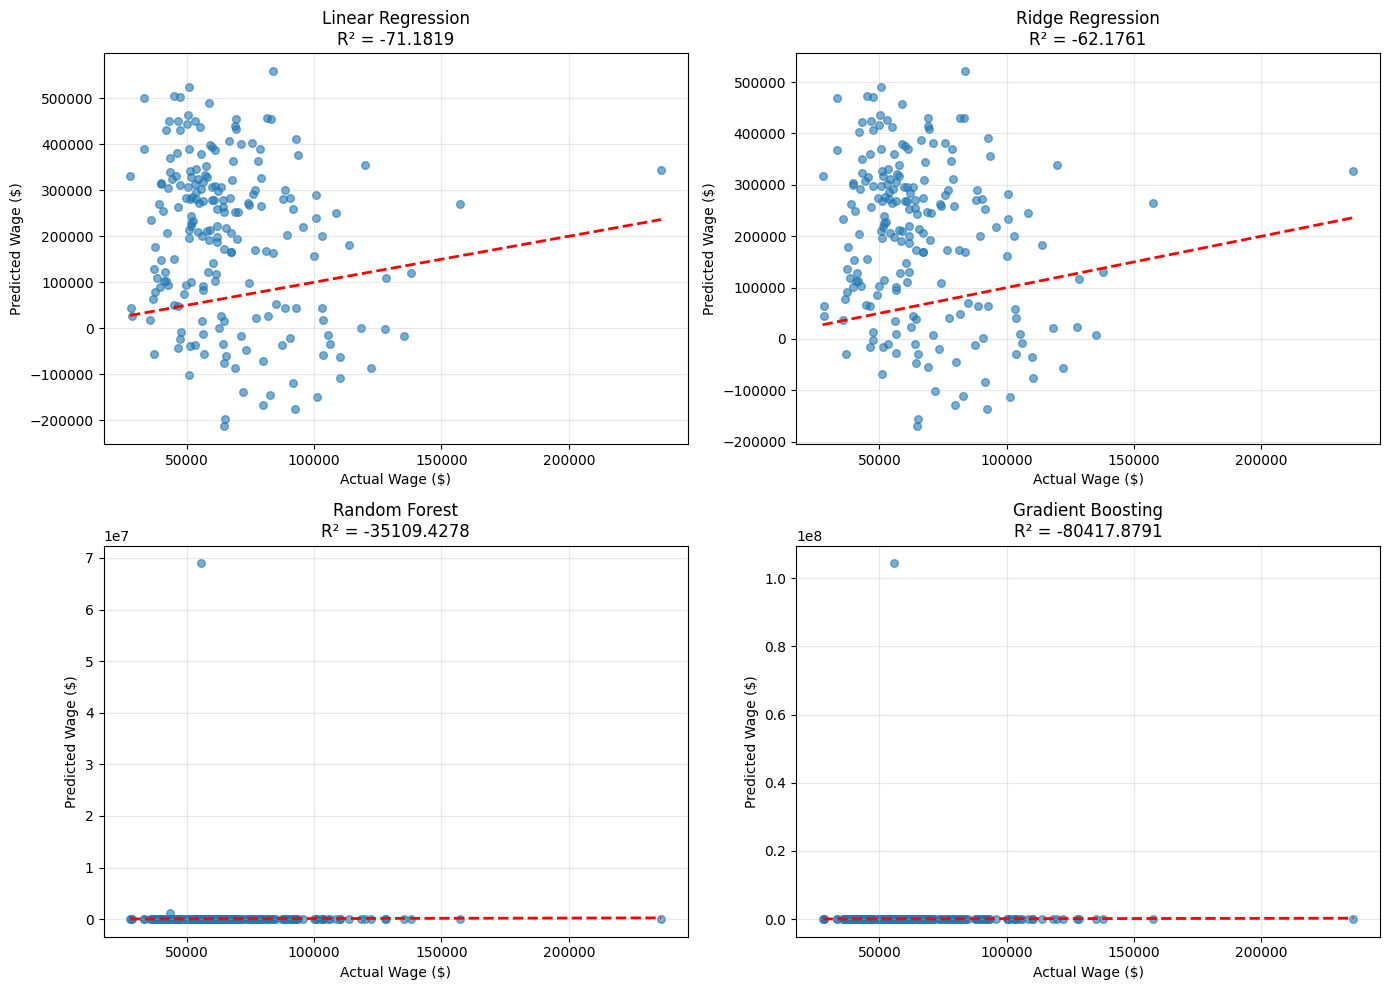

Visualization: Actual vs Predicted values for different models


In [10]:
# Visualization: Actual vs Predicted for Best Model
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

model_names = ['Linear Regression', 'Ridge Regression', 'Random Forest', 'Gradient Boosting']

for idx, model_name in enumerate(model_names):
    y_pred = results[model_name]['Predictions']
    
    axes[idx].scatter(y_test, y_pred, alpha=0.6, s=30)
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    
    r2 = results[model_name]['R2_Score']
    axes[idx].set_title(f'{model_name}\nR² = {r2:.4f}')
    axes[idx].set_xlabel('Actual Wage ($)')
    axes[idx].set_ylabel('Predicted Wage ($)')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Visualization: Actual vs Predicted values for different models")

## Model Evaluation with Custom Input

Now you can use the best model to predict prevailing wage by providing:
- Employer Name
- Year  
- Work Location (State Code)
- Occupation (Job Title)

In [11]:
# Create a function for wage level classification
def get_wage_level(wage):
    """Classify wage into levels based on quartiles"""
    q1 = df_clean['PREVAILING_WAGE'].quantile(0.25)
    q2 = df_clean['PREVAILING_WAGE'].quantile(0.50)
    q3 = df_clean['PREVAILING_WAGE'].quantile(0.75)
    
    if wage <= q1:
        return "Entry Level"
    elif wage <= q2:
        return "Mid Level"
    elif wage <= q3:
        return "Senior Level"
    else:
        return "Executive Level"

# Display wage level ranges
print("=" * 60)
print("WAGE LEVEL CLASSIFICATION")
print("=" * 60)
q1 = df_clean['PREVAILING_WAGE'].quantile(0.25)
q2 = df_clean['PREVAILING_WAGE'].quantile(0.50)
q3 = df_clean['PREVAILING_WAGE'].quantile(0.75)

print(f"Entry Level:      $ 0 - ${q1:.2f}")
print(f"Mid Level:        ${q1:.2f} - ${q2:.2f}")
print(f"Senior Level:     ${q2:.2f} - ${q3:.2f}")
print(f"Executive Level:  ${q3:.2f}+")
print("=" * 60)

WAGE LEVEL CLASSIFICATION
Entry Level:      $ 0 - $52375.25
Mid Level:        $52375.25 - $63263.50
Senior Level:     $63263.50 - $79684.75
Executive Level:  $79684.75+


In [12]:
# Function to predict wage for custom input
def predict_wage(employer_name, year, work_location, occupation):
    """
    Predict prevailing wage based on input parameters
    
    Parameters:
    - employer_name: str, company name
    - year: int, year of employment
    - work_location: str, state code (e.g., 'CA', 'NY')
    - occupation: str, job occupation/title
    
    Returns:
    - predicted_wage: float
    - wage_level: str
    """
    
    try:
        # Encode inputs using the fitted encoders
        employer_encoded = encoder_employer.transform([employer_name])[0]
        location_encoded = encoder_location.transform([work_location])[0]
        occupation_encoded = encoder_occupation.transform([occupation])[0]
        
        # Create feature vector
        input_features = np.array([[employer_encoded, year, location_encoded, occupation_encoded]])
        
        # Make prediction
        if best_model_name in ['Random Forest', 'Gradient Boosting']:
            predicted_wage = best_model.predict(input_features)[0]
        else:
            input_scaled = scaler.transform(input_features)
            predicted_wage = best_model.predict(input_scaled)[0]
        
        wage_level = get_wage_level(predicted_wage)
        
        return predicted_wage, wage_level, "Success"
    
    except Exception as e:
        return None, None, f"Error: {str(e)}"

# Example Predictions
print("\n" + "=" * 80)
print("EXAMPLE PREDICTIONS")
print("=" * 80)

test_cases = [
    ("GOOGLE", 2015, "CA", "Software Developers, Applications"),
    ("MICROSOFT CORPORATION", 2016, "WA", "Computer Systems Analysts"),
    ("IBM INDIA PRIVATE LIMITED", 2014, "NY", "Computer Programmers"),
]

for employer, year, location, occupation in test_cases:
    wage, level, status = predict_wage(employer, year, location, occupation)
    
    if status == "Success":
        print(f"\nInput:")
        print(f"  Employer: {employer}")
        print(f"  Year: {year}")
        print(f"  Location: {location}")
        print(f"  Occupation: {occupation}")
        print(f"\nPrediction:")
        print(f"  Predicted Wage: ${wage:,.2f}")
        print(f"  Wage Level: {level}")
        print("-" * 80)
    else:
        print(f"Prediction failed for {employer}: {status}")


EXAMPLE PREDICTIONS
Prediction failed for GOOGLE: Error: y contains previously unseen labels: 'GOOGLE'

Input:
  Employer: MICROSOFT CORPORATION
  Year: 2016
  Location: WA
  Occupation: Computer Systems Analysts

Prediction:
  Predicted Wage: $333,339.14
  Wage Level: Executive Level
--------------------------------------------------------------------------------
Prediction failed for IBM INDIA PRIVATE LIMITED: Error: y contains previously unseen labels: 'NY'


In [13]:
# Interactive Prediction Tool
print("\n" + "=" * 80)
print("INTERACTIVE WAGE PREDICTION TOOL")
print("=" * 80)
print("\nAvailable Employers (sample):")
print(df_clean['EMPLOYER_NAME'].unique()[:10])
print("\nAvailable Locations (sample):")
print(df_clean['WORK_LOCATION'].unique()[:10])
print("\nAvailable Occupations (sample):")
print(df_clean['SOC_NAME'].unique()[:10])
print("\nYears available:", sorted(df_clean['YEAR'].unique()))

print("\n" + "=" * 80)
print("To make a prediction, use the predict_wage() function:")
print("predict_wage(employer_name, year, work_location, occupation)")
print("\nExample:")
print("  wage, level, status = predict_wage('GOOGLE', 2016, 'CA', 'Computer Programmers')")
print("=" * 80)


INTERACTIVE WAGE PREDICTION TOOL

Available Employers (sample):
['TILA INC.' 'DATAWIN SYSTEMS INC' 'WAL-MART ASSOCIATES, INC.'
 'DYNAMIC CONSULTING LLC' 'FORD MOTOR COMPANY'
 'JAMES HARDIE BUILDING PRODUCTS INC.' 'EFFEXOFT INC'
 'MATRIX TECHNOLOGIES, INC.' 'WIPRO LIMITED'
 'RESEARCH FOUNDATION FOR MENTAL HYGIENE, INC.']

Available Locations (sample):
['TA' 'IA' 'EW' 'AN' 'RI' 'ST' 'TH' 'AS' 'EY' 'DA']

Available Occupations (sample):
['General and Operations Managers' 'Computer Programmers'
 'SOFTWARE DEVELOPERS, APPLICATIONS' 'Computer Systems Analysts'
 'Commercial and Industrial Designers' 'Mechanical Engineers'
 'Network and Computer Systems Administrators*'
 'Biological Scientists, All Other' 'Engineers, All Other' 'LAWYERS']

Years available: [np.float64(2011.0), np.float64(2012.0), np.float64(2013.0), np.float64(2014.0), np.float64(2015.0), np.float64(2016.0)]

To make a prediction, use the predict_wage() function:
predict_wage(employer_name, year, work_location, occupation)

E